# Explore IBL data Pipeline

This notebook gives an brief introduction on the IBL pipeline, and provide some guidance on how to explore the data pipeline with DataJoint tools

*DataJoint* is a general framework in Python (or Matlab) that allow users to interact with MySQL database with Python (or Matlab). To learn more, visit the website https://datajoint.io/, DataJoint Neuro is the team that develop DataJoint and help researchers to adopt DataJoint and design pipeline. To check out more, please visit https://djneuro.io/

Using DataJoint framework, we have been processing data daily within IBL project, and provides a website that display the daily training results at https://data.internationalbrainlab.org

Here we will go through some useful tools to navigate with the data itself.  

First thing first, let's **import DataJoint and the IBL pipeline package**.

In [1]:
import datajoint as dj
from ibl_pipeline import reference, subject, action, acquisition, data, behavior
from ibl_pipeline.analyses import behavior as behavior_analyses

Connecting dbadmin@datajoint-public.internationalbrainlab.org:3306


# 1. Browse schemas you have access to - `dj.list_schemas()`

Schemas are groups of tables. Tables in one schema are intuitively related.

The IBL database current have the following schemas, which could be listed with a DataJoint method:

In [ ]:
dj.list_schemas()

## Major schemas:   

1. Meta data from **Alyx**:   
    1) `ibl_reference`: general information on labs, users and projects  
    2) `ibl_subject`: subject related housing, genetic, information  
    3) `ibl_action`: surgery information  
    4) `ibl_acquisition`: session information  
    5) `ibl_data`: data managing information  
    
2. Imported data from **FlatIron**: `ibl_behavior`, trial information of the task.
3. Computed analyzed results of the behavioral data: `ibl_analyses_behavior`    

# 2. Browse tables in a schema - `dj.Diagram` or `dj.Di`  

`dj.Diagram` shows the tables and the dependencies among them. There are four types of DataJoint tables:

**Table tiers**:  

_Manual table_: green box, entries in a manual table were inserted manually and cannot recovered if deleted. A typical example of a manual table is the subject table that saves information of animal subjects  

**Lookup table**: gray box, lookup tables save general facts that are rarely changed, such as possible genetic lines of an animals, or parameter information of a model  

**Imported table**: blue oval, entries in an imported table are imported from the external data, usually with code within the DataJoint table. If deleted, the entries are recoverable if external data still exists. Examples of imported tables are tables for experimental recordings.  

**Computed table**: red circle, entries in an imported table are computed from data in the database. If deleted, the entries are easily recoverable. Examples of computed tables are tables for analyzed results.

**Part table**: plain text, tightly link to its master table, usually imported through the master table.

**Dependencies**:  
**One-to-one primary**: thick solid line, tables with one-to-one primary dependency have the exact same definition of the primary key.  

**One-to-many primary**: thin solid line, the child table inherits the primary key definition from its parent, but has additional field as part of the primary key as well.

**Secondary foreign key reference**: dashed line, a secondary attribute references to a 
Renamed secondary foreign key references: orange dot

## Show tables in the whole schema

In [ ]:
import datajoint as dj
from ibl_pipeline import reference

In [ ]:
dj.Diagram(reference)

## Show diagram of arbitruary parts of the database

A combination of arbitruary tables:

In [ ]:
dj.Diagram(subject.Subject) + dj.Diagram(subject.Line) + dj.Diagram(subject.SubjectLab) + dj.Diagram(subject.SubjectProject)

The tables could be from different schemas:

In [ ]:
dj.Diagram(subject.Subject) + dj.Diagram(acquisition.Session)

# 3. Getting the detailed definition of a table - `table.describe()`

In [ ]:
subject.Subject.describe();

# 4. Browsing of data - queries

Query all subjects

In [ ]:
subject.Subject()

## Restriction  `&`: filtering data

### Restriction: Query one subject

In [ ]:
# restrict by string
subject.Subject & 'subject_nickname="IBL-T1"'

In [ ]:
# restrict by dictionary
from uuid import UUID
subject.Subject & {'subject_uuid': UUID('00c60db3-74c3-4ee2-9df9-2c84acf84e92')}

In [ ]:
subject.Subject & {'sex': 'm'}

### Restriction: Query subjects born after a date

In [ ]:
subject.Subject & 'subject_birth_date > "2019-01-01"'

### Restriction: subjects within a range of dates

In [ ]:
subject.Subject & 'subject_birth_date between "2019-01-01" and "2019-04-01"'

### Restriction: Query subjects on multiple attributes

In [ ]:
subject.Subject & 'subject_birth_date > "2019-01-01"' & 'sex="M"'

### Restriction: Query dead subjects

In [ ]:
# subjects that are dead
subject.Subject & subject.Death

In [ ]:
# subjects that are alive
subject.Subject - subject.Death

## Join `*`:  gather information from different tables

In [ ]:
subject.Subject * acquisition.Session

## Projection `.proj()`: focus on attributes of interest

In [ ]:
subject.Subject.proj()

In [ ]:
subject.Subject.proj('subject_birth_date', 'sex')

### rename attribute with ***proj()***

In [ ]:
subject.Subject.proj('sex', dob='subject_birth_date')

### perform simple computations with ***proj***

**Example 1: Get date of a session:**

In [ ]:
sessions_with_date = acquisition.Session.proj(session_date='date(session_start_time)')

In [ ]:
sessions_with_date

**Example 2: Age of the animal when performing each session?**

In [ ]:
# First get the date of birth and the session date into the same query
q = subject.Subject * acquisition.Session

In [ ]:
q

In [ ]:
# Then compute the age
q_with_age = q.proj(age='datediff(session_start_time, subject_birth_date)')
q_with_age

## Aggregation `.aggr()`: simple computation of one table against another table

Example: how many sessions does each subject do so far?

In [ ]:
subject.Subject.aggr(acquisition.Session, 'subject_nickname', n='count(*)')

# 5. Fetching data

## Fetch all fields: `fetch()`

In [ ]:
# fetch all data from a table
subjs = subject.Subject.fetch()
subjs

In [ ]:
subjs['subject_uuid']

In [ ]:
subjs['subject_birth_date']

In [ ]:
# fetch as a list of dictionaries
subjs_dict = subject.Subject.fetch(as_dict=True)
subjs_dict

In [ ]:
# fetch as pandas dataframe
subjs_df = subject.Subject.fetch(format='frame')
subjs_df

In [ ]:
# fetch the primary key
pk = subject.Subject.fetch('KEY')
pk

In [ ]:
# fetch specific attributes
dob, sex = subject.Subject.fetch('subject_birth_date', 'sex')

In [ ]:
dob

In [ ]:
info = subject.Subject.fetch('subject_birth_date', 'sex', as_dict=True)
info

## fetch data only from one entry: `fetch1`

In [ ]:
CSHL_015 = (subject.Subject & {'subject_nickname': 'CSHL_015'}).fetch1('KEY')  # "fetch1()" because we know there's only one

In [ ]:
CSHL_015

In [ ]:
IBL_T1 = (subject.Subject & {'subject_nickname': 'IBL-T1'}).fetch1()

In [ ]:
IBL_T1

# 5. Behavioral trial information

The most important information in the data pipeline so far is the behavioral trials for the 2 alternative force choice task. We would go into a bit more details in the relevant tables.

The `behavior` schema contains tables for the behavior information. The most important table is `behavior.TrialSet`

In [3]:
behavior.TrialSet()

subject_uuid,session_start_time start time,n_trials total trial numbers in this set,n_correct_trials number of the correct trials,trials_start_time start time of the trial set (seconds),trials_end_time end time of the trial set (seconds)
088b6898-0a86-435e-b91f-eab829a846f6,2019-05-31 11:12:44,262,122,0.0,2775.06
088b6898-0a86-435e-b91f-eab829a846f6,2019-06-03 11:09:57,173,55,0.0,2816.73
088b6898-0a86-435e-b91f-eab829a846f6,2019-06-06 10:42:37,103,40,0.0,2791.59
088b6898-0a86-435e-b91f-eab829a846f6,2019-06-07 10:41:24,242,66,0.0,2762.26
088b6898-0a86-435e-b91f-eab829a846f6,2019-06-11 13:27:25,787,214,0.0,5421.34
088b6898-0a86-435e-b91f-eab829a846f6,2019-06-12 14:04:17,980,288,0.0,5409.96
088b6898-0a86-435e-b91f-eab829a846f6,2019-06-13 13:38:14,907,349,0.0,4564.7
088b6898-0a86-435e-b91f-eab829a846f6,2019-06-14 09:08:21,848,263,0.0,4365.95
088b6898-0a86-435e-b91f-eab829a846f6,2019-06-17 10:34:19,709,358,0.0,3601.85
088b6898-0a86-435e-b91f-eab829a846f6,2019-06-18 11:03:39,824,500,0.0,3641.84


The TrialSet table stores some summary statistics in one session of behavioral experiment. To also show the information of the subject, we could join the table with subject related tables.

In [4]:
behavior.TrialSet * subject.Subject * subject.SubjectLab * subject.SubjectProject

subject_uuid,session_start_time start time,subject_project,n_trials total trial numbers in this set,n_correct_trials number of the correct trials,trials_start_time start time of the trial set (seconds),trials_end_time end time of the trial set (seconds),subject_nickname nickname,sex sex,subject_birth_date birth date,ear_mark ear mark,subject_line name,subject_source name of source,protocol_number protocol number,subject_description,subject_ts,lab_name name of lab,subjectlab_ts,subjectproject_ts
088b6898-0a86-435e-b91f-eab829a846f6,2019-05-31 11:12:44,ibl_neuropixel_brainwide_01,262,122,0.0,2775.06,SWC_005,M,2019-02-05,NA (Rear HP),C57BL/6J,Charles River,4,ID: 919175,2019-09-18 01:17:36,mrsicflogellab,2019-09-18 01:17:40,2019-09-18 01:17:38
088b6898-0a86-435e-b91f-eab829a846f6,2019-06-03 11:09:57,ibl_neuropixel_brainwide_01,173,55,0.0,2816.73,SWC_005,M,2019-02-05,NA (Rear HP),C57BL/6J,Charles River,4,ID: 919175,2019-09-18 01:17:36,mrsicflogellab,2019-09-18 01:17:40,2019-09-18 01:17:38
088b6898-0a86-435e-b91f-eab829a846f6,2019-06-06 10:42:37,ibl_neuropixel_brainwide_01,103,40,0.0,2791.59,SWC_005,M,2019-02-05,NA (Rear HP),C57BL/6J,Charles River,4,ID: 919175,2019-09-18 01:17:36,mrsicflogellab,2019-09-18 01:17:40,2019-09-18 01:17:38
088b6898-0a86-435e-b91f-eab829a846f6,2019-06-07 10:41:24,ibl_neuropixel_brainwide_01,242,66,0.0,2762.26,SWC_005,M,2019-02-05,NA (Rear HP),C57BL/6J,Charles River,4,ID: 919175,2019-09-18 01:17:36,mrsicflogellab,2019-09-18 01:17:40,2019-09-18 01:17:38
088b6898-0a86-435e-b91f-eab829a846f6,2019-06-11 13:27:25,ibl_neuropixel_brainwide_01,787,214,0.0,5421.34,SWC_005,M,2019-02-05,NA (Rear HP),C57BL/6J,Charles River,4,ID: 919175,2019-09-18 01:17:36,mrsicflogellab,2019-09-18 01:17:40,2019-09-18 01:17:38
088b6898-0a86-435e-b91f-eab829a846f6,2019-06-12 14:04:17,ibl_neuropixel_brainwide_01,980,288,0.0,5409.96,SWC_005,M,2019-02-05,NA (Rear HP),C57BL/6J,Charles River,4,ID: 919175,2019-09-18 01:17:36,mrsicflogellab,2019-09-18 01:17:40,2019-09-18 01:17:38
088b6898-0a86-435e-b91f-eab829a846f6,2019-06-13 13:38:14,ibl_neuropixel_brainwide_01,907,349,0.0,4564.7,SWC_005,M,2019-02-05,NA (Rear HP),C57BL/6J,Charles River,4,ID: 919175,2019-09-18 01:17:36,mrsicflogellab,2019-09-18 01:17:40,2019-09-18 01:17:38
088b6898-0a86-435e-b91f-eab829a846f6,2019-06-14 09:08:21,ibl_neuropixel_brainwide_01,848,263,0.0,4365.95,SWC_005,M,2019-02-05,NA (Rear HP),C57BL/6J,Charles River,4,ID: 919175,2019-09-18 01:17:36,mrsicflogellab,2019-09-18 01:17:40,2019-09-18 01:17:38
088b6898-0a86-435e-b91f-eab829a846f6,2019-06-17 10:34:19,ibl_neuropixel_brainwide_01,709,358,0.0,3601.85,SWC_005,M,2019-02-05,NA (Rear HP),C57BL/6J,Charles River,4,ID: 919175,2019-09-18 01:17:36,mrsicflogellab,2019-09-18 01:17:40,2019-09-18 01:17:38
088b6898-0a86-435e-b91f-eab829a846f6,2019-06-18 11:03:39,ibl_neuropixel_brainwide_01,824,500,0.0,3641.84,SWC_005,M,2019-02-05,NA (Rear HP),C57BL/6J,Charles River,4,ID: 919175,2019-09-18 01:17:36,mrsicflogellab,2019-09-18 01:17:40,2019-09-18 01:17:38


We could restrict to one session by:

In [5]:
import datetime
q = behavior.TrialSet * subject.Subject * subject.SubjectLab * subject.SubjectProject & \
    'subject_nickname="CSHL_015"' & {'session_start_time': datetime.datetime(2019, 9, 16, 13, 44, 46)}
q

subject_uuid,session_start_time start time,subject_project,n_trials total trial numbers in this set,n_correct_trials number of the correct trials,trials_start_time start time of the trial set (seconds),trials_end_time end time of the trial set (seconds),subject_nickname nickname,sex sex,subject_birth_date birth date,ear_mark ear mark,subject_line name,subject_source name of source,protocol_number protocol number,subject_description,subject_ts,lab_name name of lab,subjectlab_ts,subjectproject_ts
10fd3170-6c52-4cb6-986f-aa73704277c0,2019-09-16 13:44:46,ibl_neuropixel_brainwide_01,940,715,0.0,4804.95,CSHL_015,F,2019-02-19,None,C57BL/6J,Jax,3,None,2019-09-18 01:17:36,churchlandlab,2019-09-18 01:17:40,2019-09-18 01:17:38


The trial-by-trial information are shown in a **part table** `behavior.TrialSet.Trial`

In [6]:
behavior.TrialSet.Trial()

subject_uuid,session_start_time start time,trial_id trial identification number,trial_start_time beginning of quiescent period time (seconds),trial_end_time end of iti (seconds),"trial_response_time Time of ""response"" in choiceworld (seconds). This is when one of the three possible choices is registered in software, will not be the same as when the mouse's movement to generate that response begins.",trial_response_choice which choice was made in choiceworld,trial_stim_on_time Time of stimulus in choiceworld (seconds),trial_stim_contrast_left contrast of the stimulus on the left,trial_stim_contrast_right contrast of the stimulus on the right,trial_feedback_time Time of feedback delivery (reward or not) in choiceworld,"trial_feedback_type whether feedback is positive or negative in choiceworld (-1 for negative, +1 for positive)","trial_rep_num the repetition number of the trial, i.e. how many trials have been repeated on this side (counting from 1)",trial_go_cue_time,trial_go_cue_trigger_time,trial_stim_prob_left probability of the stimulus being present on left,trial_reward_volume reward volume of each trial,trial_iti_duration inter-trial interval,trial_included whether the trial should be included
088b6898-0a86-435e-b91f-eab829a846f6,2019-05-31 11:12:44,1,0.0,5.061203,3.0612000000000004,CCW,0.5422,0.5,0.0,3.0612000000000004,-1,None,nan,0.474,0.5,nan,nan,None
088b6898-0a86-435e-b91f-eab829a846f6,2019-05-31 11:12:44,2,5.4478,18.177502,16.177500000000002,CCW,6.0327,0.5,0.0,16.177500000000002,-1,None,nan,5.9789,1.0,nan,nan,None
088b6898-0a86-435e-b91f-eab829a846f6,2019-05-31 11:12:44,3,18.6118,37.385403000000004,35.385400000000004,CCW,21.2575,0.5,0.0,35.385400000000004,-1,None,nan,21.2072,1.0,nan,nan,None
088b6898-0a86-435e-b91f-eab829a846f6,2019-05-31 11:12:44,4,37.8545,48.358902,46.358900000000006,CCW,39.7319,0.5,0.0,46.358900000000006,-1,None,nan,39.6789,1.0,nan,nan,None
088b6898-0a86-435e-b91f-eab829a846f6,2019-05-31 11:12:44,5,48.760200000000005,51.507103,50.50710000000001,CW,49.4243,0.5,0.0,50.50710000000001,1,None,nan,49.3592,1.0,nan,nan,None
088b6898-0a86-435e-b91f-eab829a846f6,2019-05-31 11:12:44,6,51.824101000000006,58.649703,57.64970100000001,CW,54.064901000000006,1.0,0.0,57.64970100000001,1,None,nan,54.0204,0.5,nan,nan,None
088b6898-0a86-435e-b91f-eab829a846f6,2019-05-31 11:12:44,7,59.0185,80.112803,79.11280000000001,CW,65.0905,1.0,0.0,79.11280000000001,1,None,nan,65.0341,0.5,nan,nan,None
088b6898-0a86-435e-b91f-eab829a846f6,2019-05-31 11:12:44,8,80.6187,93.143103,92.1431,CW,85.5976,1.0,0.0,92.1431,1,None,nan,85.5413,0.5,nan,nan,None
088b6898-0a86-435e-b91f-eab829a846f6,2019-05-31 11:12:44,9,93.5483,100.322103,99.32209999999999,CCW,94.1571,0.0,1.0,99.32209999999999,1,None,nan,94.1033,0.5,nan,nan,None
088b6898-0a86-435e-b91f-eab829a846f6,2019-05-31 11:12:44,10,100.6829,105.105603,104.10560000000001,CCW,103.7472,0.0,1.0,104.10560000000001,1,None,nan,103.699,0.5,nan,nan,None


We could check the documentation of each of the column with `describe()`

In [2]:
behavior.TrialSet.Trial.describe();

-> behavior.TrialSet
trial_id             : int                          # trial identification number
---
trial_start_time     : double                       # beginning of quiescent period time (seconds)
trial_end_time       : double                       # end of iti (seconds)
trial_response_time=null : double                       # Time of "response" in choiceworld (seconds). This is when one of the three possible choices is registered in software, will not be the same as when the mouse's movement to generate that response begins.
trial_response_choice : enum('CCW','CW','No Go')     # which choice was made in choiceworld
trial_stim_on_time=null : double                       # Time of stimulus in choiceworld (seconds)
trial_stim_contrast_left : float                        # contrast of the stimulus on the left
trial_stim_contrast_right : float                        # contrast of the stimulus on the right
trial_feedback_time=null : double                       # Time of feedback 

To fetch some part of data, we could do use the fetch method:  

For example we would like to see the stimulus contrasts, and the animal choices in one session (that we already queried and saved the results as q), we could do:

In [17]:
# we could fetch the fields as a list of dictionary, only for the trials with a choice
data = (behavior.TrialSet.Trial & q & 'trial_response_choice !="No Go"').fetch(
    'trial_stim_contrast_left', 'trial_stim_contrast_right', 'trial_response_choice', as_dict=True)

/usr/local/lib/python3.6/dist-packages/datajoint/connection.py:212: UserWarning: MySQL server has gone away. Reconnecting to the server.
  warnings.warn("MySQL server has gone away. Reconnecting to the server.")


In [18]:
# We could then convert the data to a dataframe for further analyses
import pandas as pd
df = pd.DataFrame(data)
df

,trial_response_choice,trial_stim_contrast_left,trial_stim_contrast_right
0,CCW,0.0000,0.0000
1,CCW,0.0625,0.0000
2,CCW,0.0000,1.0000
3,CCW,0.0000,1.0000
4,CW,0.0000,0.1250
...,...,...,...
915,CCW,0.0000,0.2500
916,CCW,0.0000,0.0625
917,CCW,0.0000,0.0000
918,CCW,0.0000,0.0000


Then we can do some computation here to explore the data.

We first compute the signed contrast, so that the contrasts on the right are positive

In [19]:
df['signed_contrast'] = df['trial_stim_contrast_right'] - df['trial_stim_contrast_left']

In [20]:
df['report_right'] = df['trial_response_choice'] == "CCW"

In [28]:
report_right = df.groupby(['signed_contrast'], as_index=False).mean()
report_right

,signed_contrast,trial_stim_contrast_left,trial_stim_contrast_right,report_right
0,-1.0000,1.0000,0.0000,0.010870
1,-0.2500,0.2500,0.0000,0.111111
2,-0.1250,0.1250,0.0000,0.160920
3,-0.0625,0.0625,0.0000,0.289474
4,0.0000,0.0000,0.0000,0.348066
5,0.0625,0.0000,0.0625,0.694737
6,0.1250,0.0000,0.1250,0.627660
7,0.2500,0.0000,0.2500,0.765306
8,1.0000,0.0000,1.0000,0.867347


Then let's plot the psychometric curve: prob_report_right vs signed_contrast:

<IPython.core.display.Javascript object>


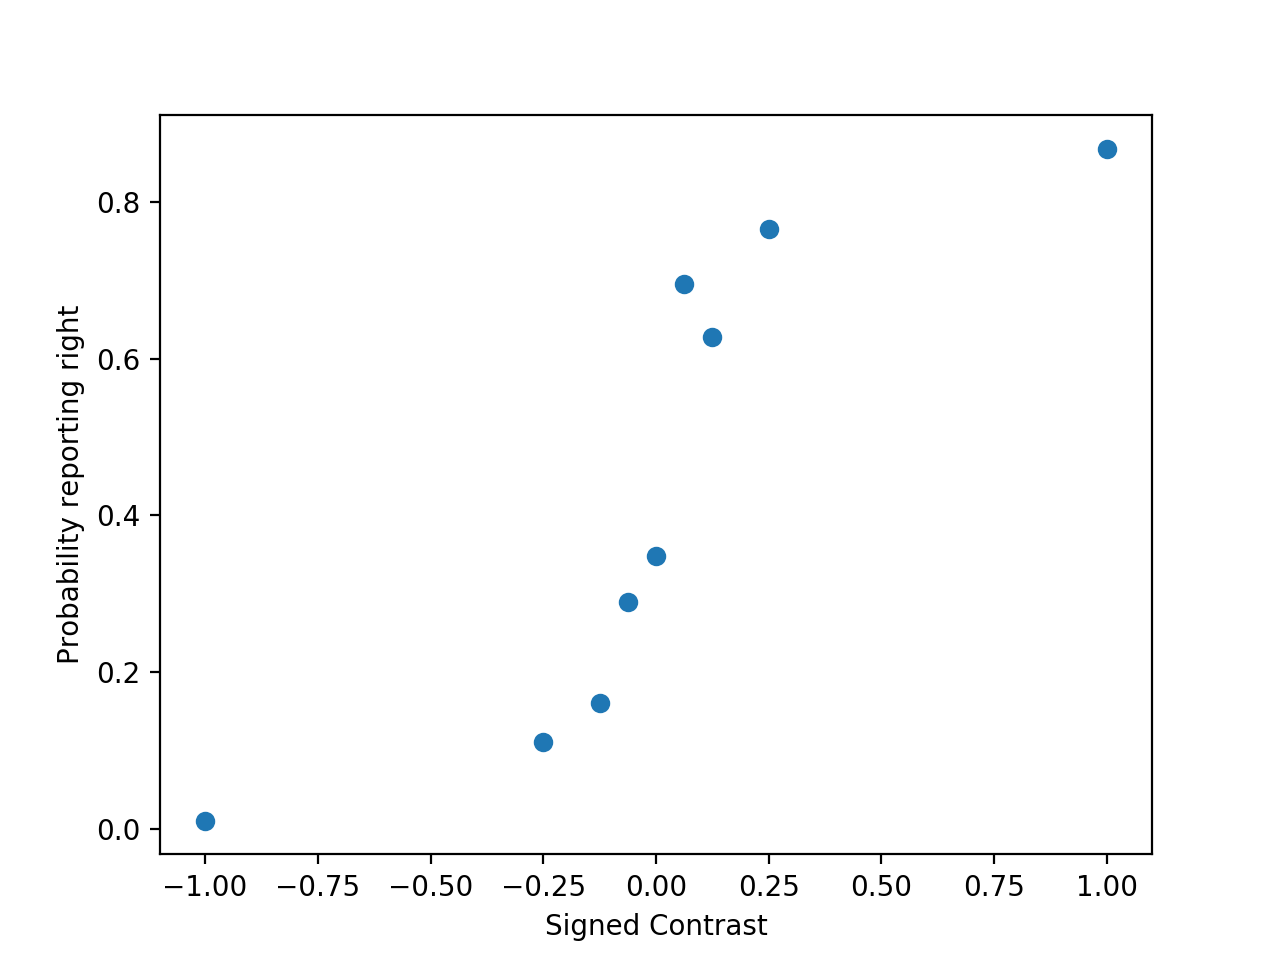

Text(0, 0.5, 'Probability reporting right')

In [35]:
import matplotlib.pyplot as plt
%matplotlib notebook
plt.plot(report_right['signed_contrast'], report_right['report_right'], 'o')
plt.xlabel('Signed Contrast')
plt.ylabel('Probability reporting right')

Some basic analyses such as psychometric curves have been pre-processed and saved in the downstream tables, such as `behavior_analyses.PsychResults`. In the next notebook, we would like to step through how to fetch data from that table and recreate the psychometric curves for a particular session.